<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-4/4_0_1_HIL_interrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human in the loop interrupt

In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph

# Case 0 - Basic Usage
https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#simple-usage

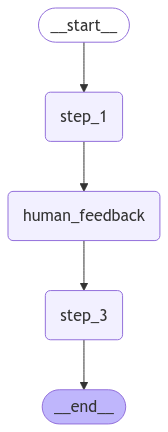

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langgraph.types import Command, interrupt


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")

    feedback = interrupt({"Please provide feedback:": "WAITING to Start"})

    print("\n\n[GOT BACK FROM HUMAN AFTER INTERRUPT:]\n\n", feedback)
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Input
initial_input = {"input": "hello we are learning interrupt"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

# State Get
# State Update
# Continue

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value={'Please provide feedback:': 'WAITING to Start'}, resumable=True, ns=['human_feedback:7900fc9a-6a58-b268-16c9-e2ce129a4d5e'], when='during'),)}




In [6]:
# HOW TO RESUME
# Continue the graph execution
for event in graph.stream(
    Command(resume="Requesting to Start"),
    thread,
    stream_mode="updates"
):
    print(event)
    print("\n")

---human_feedback---


[GOT BACK FROM HUMAN AFTER INTERRUPT:]

 Requesting to Start
{'human_feedback': {'user_feedback': 'Requesting to Start'}}


---Step 3---
{'step_3': None}




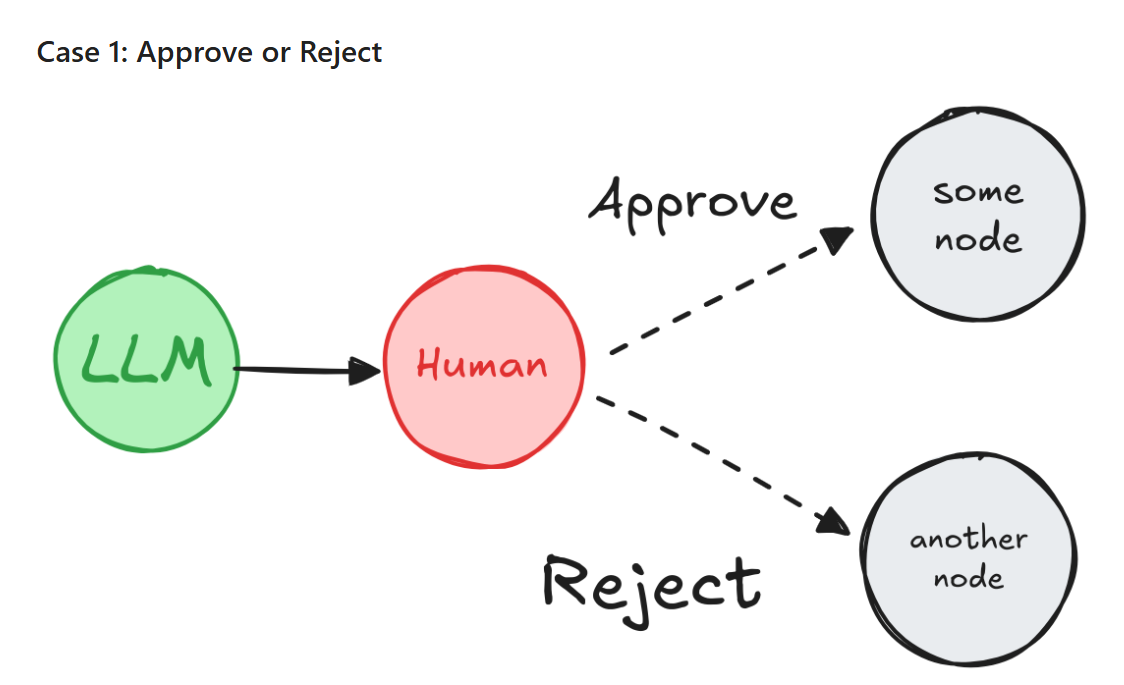

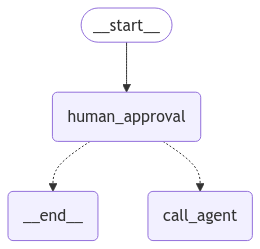

In [7]:
from typing_extensions import TypedDict
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langgraph.types import Command, interrupt


class State(TypedDict):
    input: str

def human_approval(state) -> Command[Literal["__end__", "call_agent"]]:
    print("---human_feedback---")

    is_approved = interrupt("Is this correct?")

    print("\n\n[RESUME AFTER INTERRUPT:]\n\n", is_approved)

    if is_approved == "yes":
        return Command(goto="call_agent")
    else:
        return Command(goto="__end__")


def call_agent(state):
    print("---call_agent 3---")
    pass


builder = StateGraph(State)
builder.add_node("human_approval", human_approval)
builder.add_node("call_agent", call_agent)

builder.add_edge(START, "human_approval")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Input
initial_input = {"input": "hello from UMT Lahore"}

# Thread
thread = {"configurable": {"thread_id": "11122232"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---human_feedback---
{'__interrupt__': (Interrupt(value='Is this correct?', resumable=True, ns=['human_approval:121aaaa2-5408-94b7-3ab1-64e569459b42'], when='during'),)}




In [9]:
# HOW TO RESUME
# Continue the graph execution
for event in graph.stream(
    Command(resume={"": ""}),
    thread,
    stream_mode="updates"
):
    print(event)
    print("\n")


---human_feedback---


[RESUME AFTER INTERRUPT:]

 {'': ''}
{'human_approval': None}




## Case 2 Tool Calling - Review/Reject
https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#review-tool-calls